# Importing the required modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import networkx as nx

# Fetching the Dataset

We use two datasets, `messages` and `employees`. Te datasets are obtained using the `pd.read_csv("file_name.csv")` method. Let's explore the initial few rows and gather information about the columns.

## Dataset Overview

The `employee` DataFrame consists of the following columns:

1. **id:** An integer representing the ID of employee
2. **department:** A categorical variable indicating the department name
3. **location:** The location of the employee
4. **age:** The age of the employee working

The `messages` DataFrame consists of the following columns:

1. **sender:** The ID of the sender sending message
2. **receiver:** The ID of the receiver receiving message
3. **timestamp:** The time at which message is sent expressed in DD:MM:YYYY HH:MM
4. **message_length:** The length of the message between sender and receiver


In [2]:
messages = pd.read_csv("/content/65d8041286f16_messages.csv")
employees = pd.read_csv("/content/65d8041c9be59_employees.csv")

In [3]:
messages.head()

,sender,receiver,timestamp,message_length
0,79,48,2021-06-02 05:41:34,88
1,79,63,2021-06-02 05:42:15,72
2,79,58,2021-06-02 05:44:24,86
3,79,70,2021-06-02 05:49:07,26
4,79,109,2021-06-02 19:51:47,73


In [4]:
employees.head()

,id,department,location,age
0,3,Operations,US,33
1,6,Sales,UK,50
2,8,IT,Brasil,54
3,9,Admin,UK,32
4,12,Operations,Brasil,51


# Distribution of employees across age groups

In [5]:
# Create bins for age starting from 20, ending at 60 with width 5
bins = [i for i in range(20, 61, 5)]

In [6]:
# Cut the data into bins
employees['age_group'] = pd.cut(employees['age'], bins=bins, right=False)

In [7]:
# Count the number of people in each age group
age_counts = employees['age_group'].value_counts().sort_index()

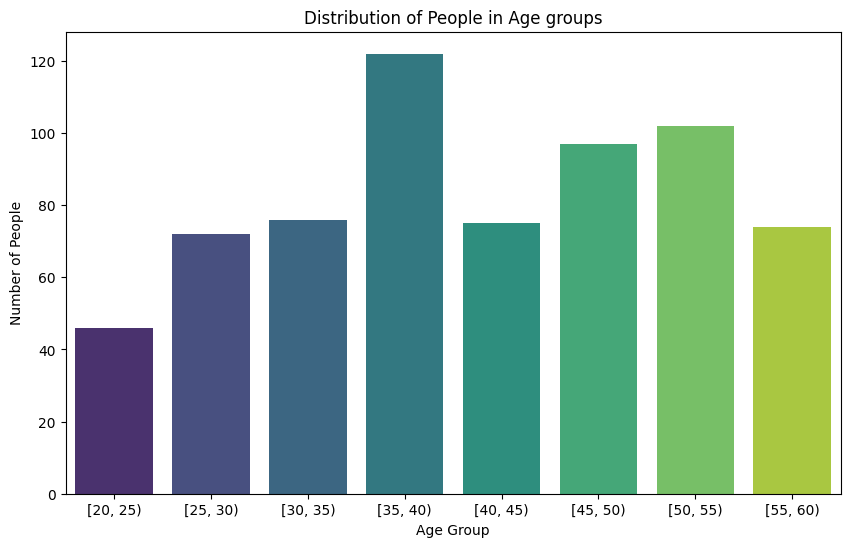

In [8]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=age_counts.index, y=age_counts.values, hue=age_counts.index, palette='viridis', legend=False)
plt.title('Distribution of People in Age groups')
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.show()

**We find that majority working class people fall under the 35-40 years age category, followed by 50-55 and 40-45 age group**

# Distribution of people by location and department

In [11]:
# Group by location and department, then calculate the sum of people
grouped_data = employees.groupby(['location', 'department']).size().unstack().fillna(0)

<Figure size 1200x600 with 0 Axes>

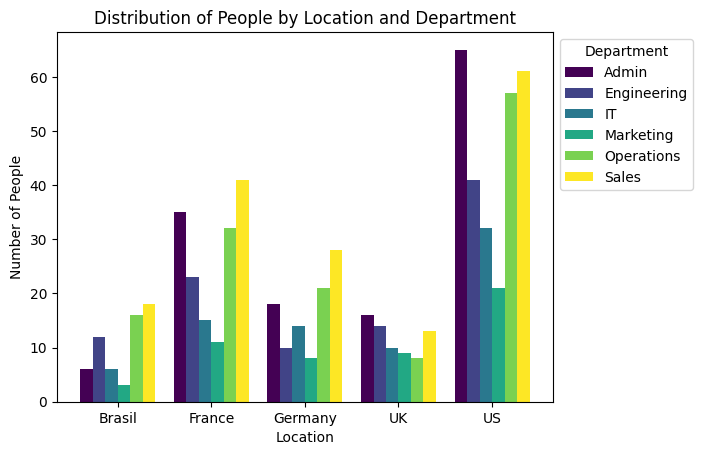

In [12]:
# Plot the data as clustered columns
plt.figure(figsize=(12, 6))
grouped_data.plot(kind='bar', width=0.8, colormap='viridis')
plt.title('Distribution of People by Location and Department')
plt.xlabel('Location')
plt.ylabel('Number of People')
plt.xticks(rotation=0)
plt.legend(title='Department', bbox_to_anchor=(1, 1))
plt.show()

**US has the highest number of employees with Admin department employing highest number of employees**

# Frequency of messages sent and received over the year

In [13]:
messages = pd.DataFrame(messages)
messages['timestamp'] = pd.to_datetime(messages['timestamp'])

In [14]:
# Extract day from the timestamp
messages['day'] = messages['timestamp'].dt.date

In [15]:
# Count the number of calls per day
calls_per_day = messages.groupby('day').size().reset_index(name='call_count')

In [16]:
# Convert 'day' to datetime type
calls_per_day['day'] = pd.to_datetime(calls_per_day['day'])

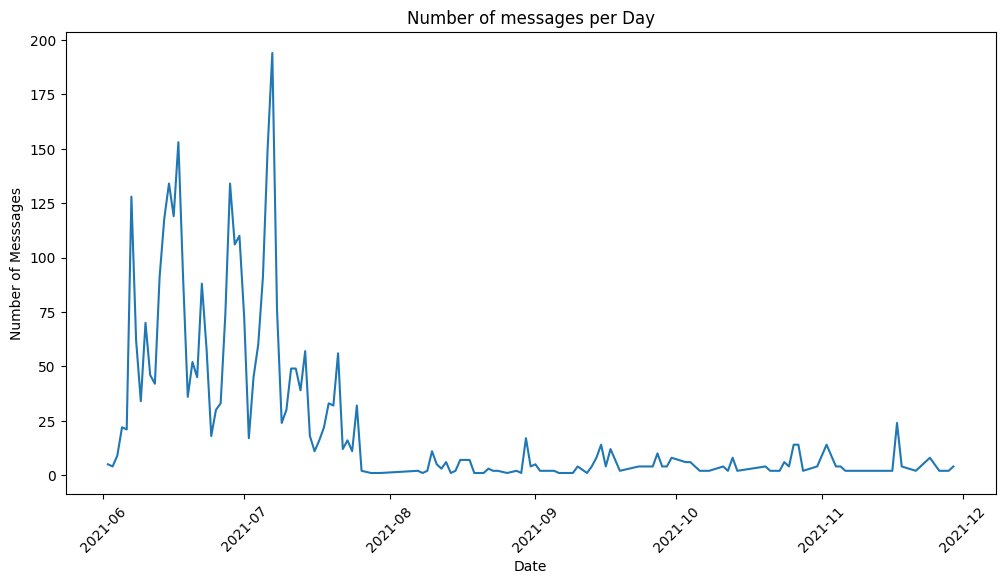

In [17]:
# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(calls_per_day['day'], calls_per_day['call_count'])
plt.title('Number of messages per Day')
plt.xlabel('Date')
plt.ylabel('Number of Messsages')
plt.xticks(rotation=45)
plt.show()

**We find that most of the messages are sent and received in the period 2021-06 to 2021-08 followed by a gradual decrease**

# Distribution of message length over frequency

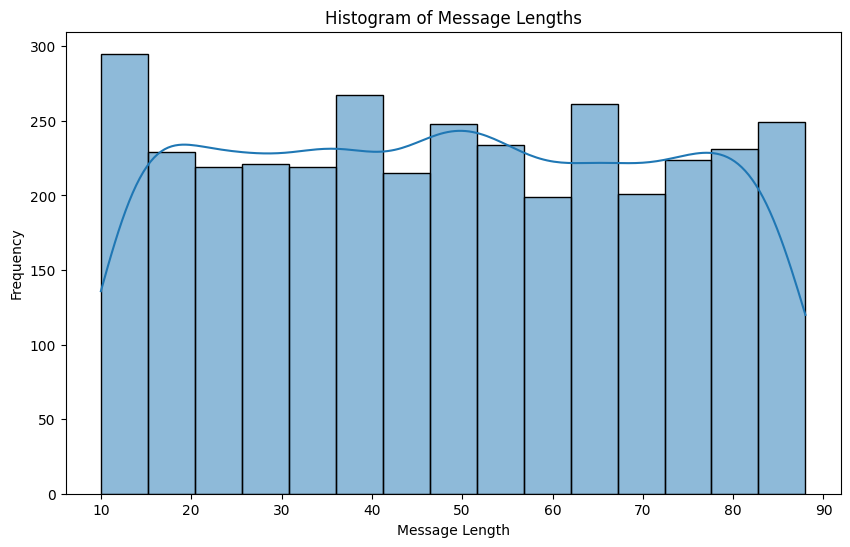

In [18]:
# Histogram of Message Lengths
plt.figure(figsize=(10, 6))
sns.histplot(messages['message_length'], bins=15, kde=True)
plt.title('Histogram of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

**We find that the messages of length 10-15 have the highest frequency, followed by messages of length 35-40 and 60-65**

# Distribution of peak duration in sending and receiving messages

In [19]:
messages = pd.DataFrame(messages)
messages['timestamp'] = pd.to_datetime(messages['timestamp'])

In [20]:
# Extract hour and minute from the timestamp
messages['hour'] = messages['timestamp'].dt.hour

In [21]:
# Combine sender and receiver messages
all_messages = pd.concat([messages['hour'], messages['hour']], keys=['Sent', 'Received'])

In [22]:
# Count the number of messages per hour
message_counts = all_messages.groupby(all_messages).size().reset_index(name='count')

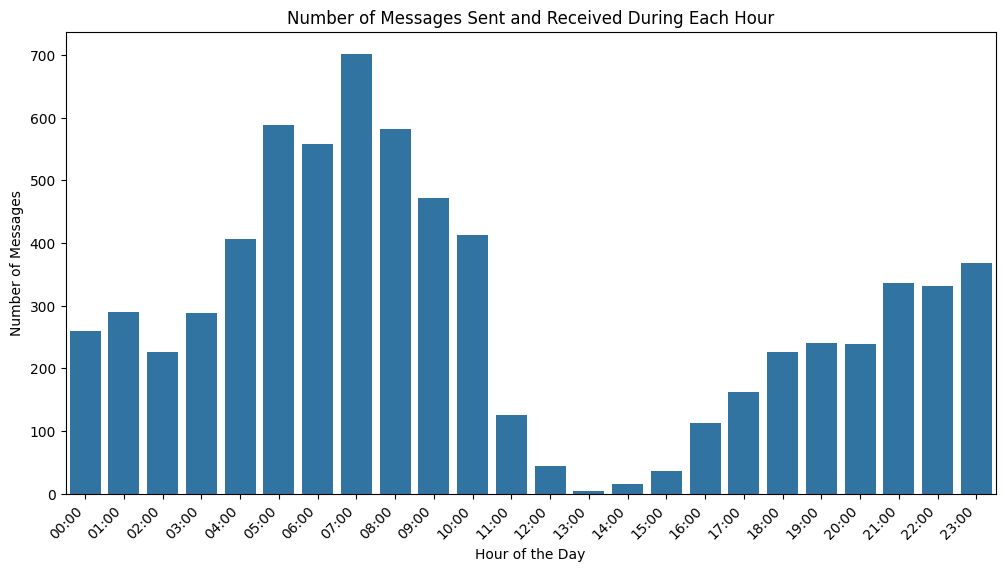

In [23]:
# Plot the bar chart with time on x-axis and number of messages on y-axis
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', data=message_counts)
plt.title('Number of Messages Sent and Received During Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45, ha='right')
plt.xticks(range(24), [f'{hour:02}:00' for hour in range(24)])

plt.show()

**We find that the peak hours in message flow is between 7-8 am**

# Messages sent by each department

In [24]:
# Merge datasets
merged_sender = pd.merge(messages, employees, left_on='sender', right_on='id', how='inner')
merged_receiver = pd.merge(messages, employees, left_on='receiver', right_on='id', how='inner')

In [25]:
# Identify Active Departments
active_departments_sender = merged_sender.groupby('department')['message_length'].count().reset_index()
active_departments_receiver = merged_receiver.groupby('department')['message_length'].count().reset_index()
active_departments = active_departments_sender.merge(active_departments_receiver, on='department', suffixes=('_sender', '_receiver'), how='outer')
active_departments['total_messages'] = active_departments['message_length_sender'].fillna(0) + active_departments['message_length_receiver'].fillna(0)

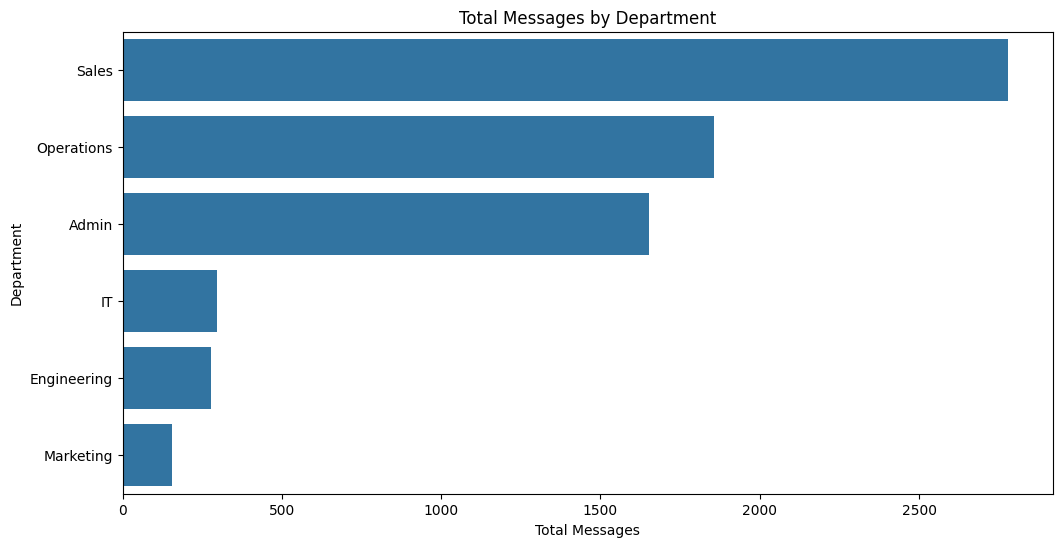

In [26]:
# Active Departments
plt.figure(figsize=(12, 6))
sns.barplot(x='total_messages', y='department', data=active_departments.sort_values(by='total_messages', ascending=False))
plt.title('Total Messages by Department')
plt.xlabel('Total Messages')
plt.ylabel('Department')
plt.show()

**We find that Sales department sends the most messages and Marketing department send the least messages**

# Employees with highest connections

In [27]:
# Employee Connections
employee_connections = pd.concat([merged_sender['sender'], merged_receiver['receiver']])
most_connected_employee = employee_connections.value_counts().idxmax()

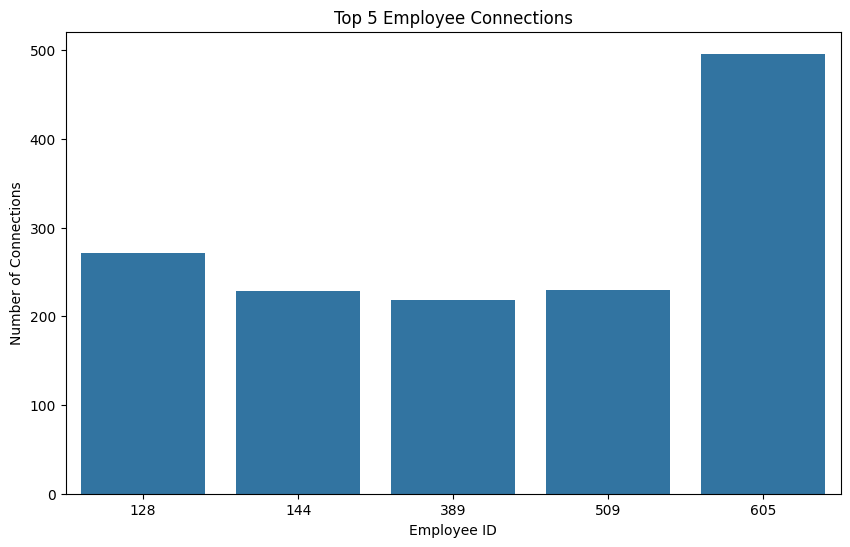

In [28]:
# Plot Employee Connections
plt.figure(figsize=(10, 6))
sns.barplot(x=employee_connections.value_counts().index[:5], y=employee_connections.value_counts().values[:5])
plt.title('Top 5 Employee Connections')
plt.xlabel('Employee ID')
plt.ylabel('Number of Connections')
plt.show()

**We find that employee with ID 605 has the highest number of connections**

# Most influential employees in the company

In [29]:
# Influential Departments and Employees
influential_departments = merged_sender.groupby('department')['id'].nunique().reset_index()
influential_employees = pd.concat([merged_sender['sender'], merged_receiver['receiver']]).value_counts().reset_index()
influential_employees.columns = ['id', 'connections']
most_influential_department = influential_departments.loc[influential_departments['id'].idxmax(), 'department']
most_influential_employee = influential_employees.loc[influential_employees['connections'].idxmax(), 'id']

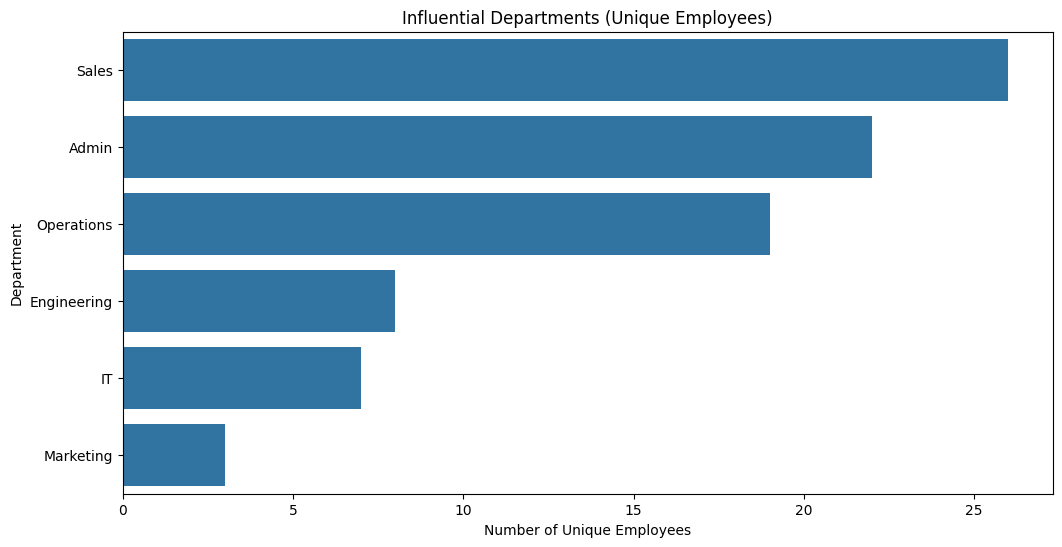

In [30]:
# Influential Departments
plt.figure(figsize=(12, 6))
sns.barplot(x='id', y='department', data=influential_departments.sort_values(by='id', ascending=False))
plt.title('Influential Departments (Unique Employees)')
plt.xlabel('Number of Unique Employees')
plt.ylabel('Department')
plt.show()

**We find that Sales department as the most number of influential employees**

# Interaction of people within the departments

In [34]:
# Merge datasets
merged_sender = pd.merge(messages, employees, left_on='sender', right_on='id', how='inner')
merged_receiver = pd.merge(messages, employees, left_on='receiver', right_on='id', how='inner')

In [35]:
# Create Department Interaction Matrix
interaction_matrix = pd.crosstab(merged_sender['department'], merged_receiver['department'])

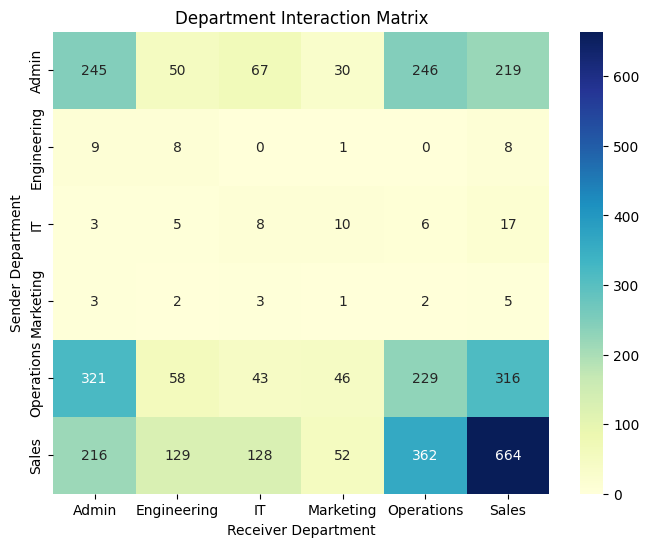

In [76]:
# Visualize Department Interaction Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(interaction_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Department Interaction Matrix')
plt.xlabel('Receiver Department')
plt.ylabel('Sender Department')
plt.show()

**We find that Sales deparment has the highest number of interactions with Operations**

# Employees with highest number of connections

In [37]:
# Merge datasets
merged_sender = pd.merge(messages, employees, left_on='sender', right_on='id', how='inner')
merged_receiver = pd.merge(messages, employees, left_on='receiver', right_on='id', how='inner')

In [38]:
# Combine sender and receiver employee IDs
employee_connections = pd.concat([merged_sender['sender'], merged_receiver['receiver']])

In [39]:
# Determine the top 5 employees with the highest number of connections
top_5_connected_employees = employee_connections.value_counts().nlargest(5)

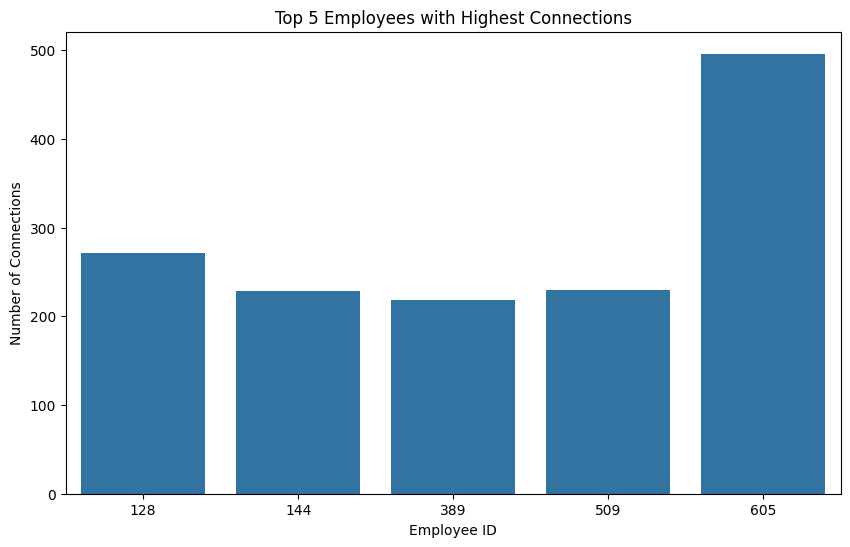

In [40]:
# Plot the top 5 connected employees
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_connected_employees.index, y=top_5_connected_employees.values)
plt.title('Top 5 Employees with Highest Connections')
plt.xlabel('Employee ID')
plt.ylabel('Number of Connections')
plt.show()

**Employee with ID 605 the highest number of connections**

# Active departments by messages

In [41]:
# Merge datasets
merged_sender = pd.merge(messages, employees, left_on='sender', right_on='id', how='inner')
merged_receiver = pd.merge(messages, employees, left_on='receiver', right_on='id', how='inner')

In [42]:
# Calculate total messages by department
active_departments_sender = merged_sender.groupby('department')['message_length'].count().reset_index()
active_departments_receiver = merged_receiver.groupby('department')['message_length'].count().reset_index()
active_departments = active_departments_sender.merge(active_departments_receiver, on='department', suffixes=('_sender', '_receiver'), how='outer')
active_departments['total_messages'] = active_departments['message_length_sender'].fillna(0) + active_departments['message_length_receiver'].fillna(0)

In [43]:
# Identify most/least active departments
most_active_department = active_departments.loc[active_departments['total_messages'].idxmax(), 'department']
least_active_department = active_departments.loc[active_departments['total_messages'].idxmin(), 'department']

In [44]:
print(f"The most active department is: {most_active_department}")
print(f"The least active department is: {least_active_department}")

The most active department is: Sales
The least active department is: Marketing


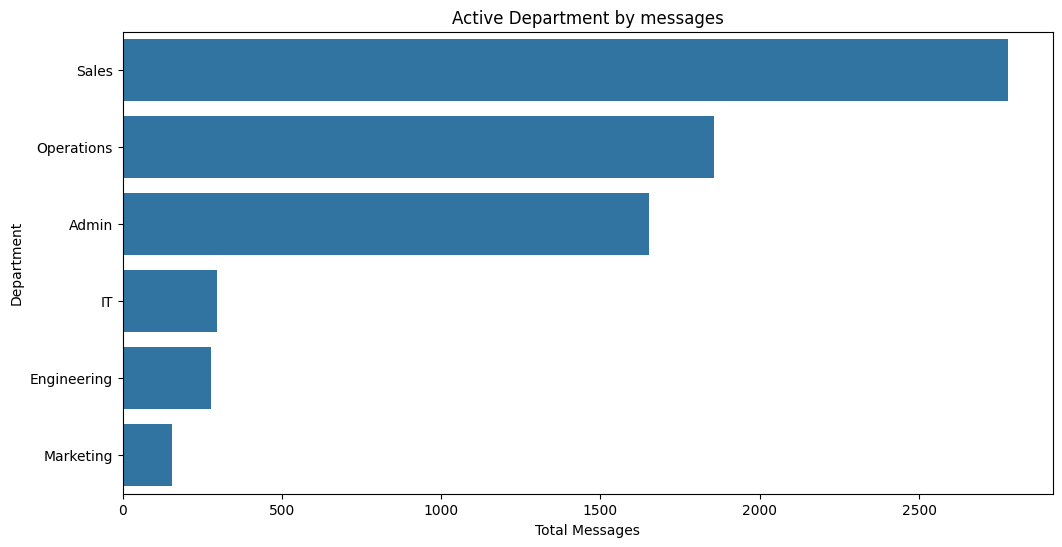

In [45]:
# Plot Total Messages by Department
plt.figure(figsize=(12, 6))
sns.barplot(x='total_messages', y='department', data=active_departments.sort_values(by='total_messages', ascending=False))
plt.title('Active Department by messages')
plt.xlabel('Total Messages')
plt.ylabel('Department')
plt.show()

**We find that Sales is the most active department and Marketing is the least active department**

# Employees under the most active age group

In [46]:
# Merge datasets
merged_sender = pd.merge(messages, employees, left_on='sender', right_on='id', how='inner')
merged_receiver = pd.merge(messages, employees, left_on='receiver', right_on='id', how='inner')

In [47]:
# Categorize age into bins of 5 starting from 20
bins = list(range(20, max(employees['age']) + 6, 5))
labels = [f"{i}-{i+4}" for i in bins[:-1]]
employees['age_group'] = pd.cut(employees['age'], bins=bins, labels=labels, right=False)

In [48]:
# Calculate total messages by age group
active_employees_sender = merged_sender.groupby('age_group')['message_length'].count().reset_index()
active_employees_receiver = merged_receiver.groupby('age_group')['message_length'].count().reset_index()
active_employees = active_employees_sender.merge(active_employees_receiver, on='age_group', suffixes=('_sender', '_receiver'), how='outer')
active_employees['total_messages'] = active_employees['message_length_sender'].fillna(0) + active_employees['message_length_receiver'].fillna(0)

In [49]:
# Identify the age group with the most active employees
most_active_age_group = active_employees.loc[active_employees['total_messages'].idxmax(), 'age_group']

In [50]:
print(f"The age group with the most active employees is: {most_active_age_group}")

The age group with the most active employees is: [35, 40)


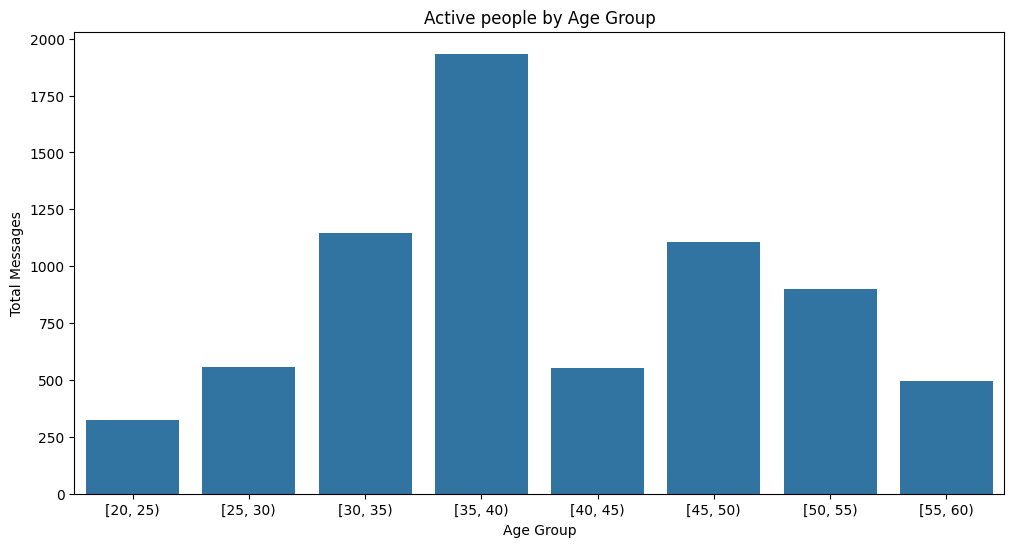

In [51]:
# Plot Total Messages by Age Group
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='total_messages', data=active_employees.sort_values(by='total_messages', ascending=False))
plt.title('Active people by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Messages')
plt.show()

**35-40 years of age is the most active age group**

# Location with most messages

In [59]:
# Calculate total messages by location
active_employees_sender = merged_sender.groupby('location')['message_length'].count().reset_index()
active_employees_receiver = merged_receiver.groupby('location')['message_length'].count().reset_index()
active_employees = active_employees_sender.merge(active_employees_receiver, on='location', suffixes=('_sender', '_receiver'), how='outer')
active_employees['total_messages'] = active_employees['message_length_sender'].fillna(0) + active_employees['message_length_receiver'].fillna(0)

In [60]:
# Identify the location with the most active employees
most_active_location = active_employees.loc[active_employees['total_messages'].idxmax(), 'location']

In [61]:
print(f"The location with the most active employees is: {most_active_location}")

The location with the most active employees is: US


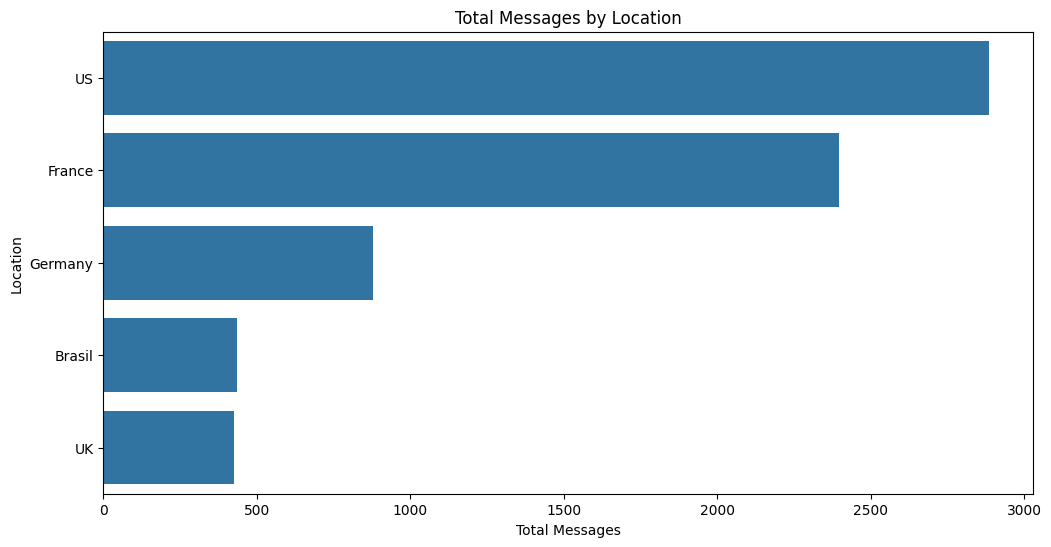

In [62]:
# Plot Total Messages by Location
plt.figure(figsize=(12, 6))
sns.barplot(x='total_messages', y='location', data=active_employees.sort_values(by='total_messages', ascending=False))
plt.title('Total Messages by Location')
plt.xlabel('Total Messages')
plt.ylabel('Location')
plt.show()

**We find that US receives the most messages and UK receives the least messages**

In [71]:
# Merge datasets
merged_sender = pd.merge(messages, employees, left_on='sender', right_on='id', how='inner')
merged_receiver = pd.merge(messages, employees, left_on='receiver', right_on='id', how='inner')

In [72]:
# Combine sender and receiver employee IDs
employee_connections = pd.concat([merged_sender[['id', 'department']], merged_receiver[['id', 'department']]])

In [73]:
# Rename columns for clarity
employee_connections.columns = ['id', 'department']

In [74]:
# Calculate top connections
top_connections = employee_connections.groupby(['id', 'department']).size().reset_index(name='connection_count').nlargest(5, 'connection_count')

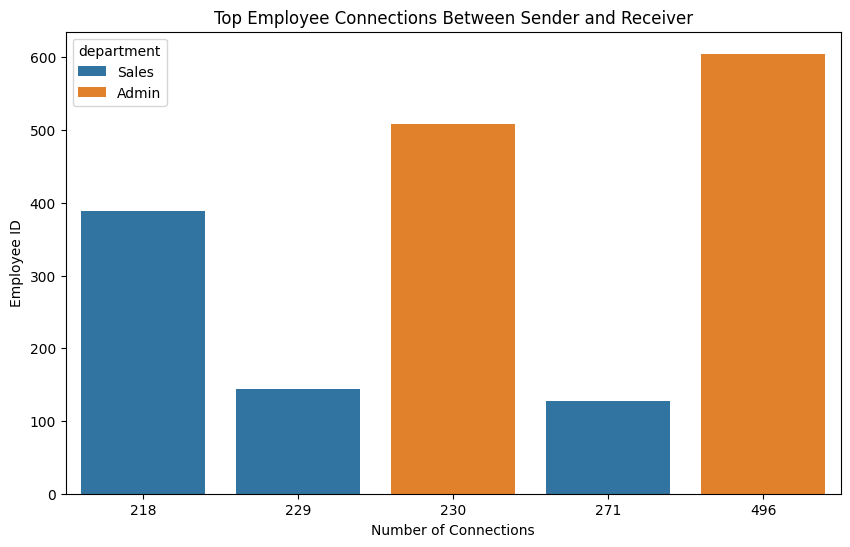

In [70]:
# Plot Top Employee Connections
plt.figure(figsize=(10, 6))
sns.barplot(x='connection_count', y='id', hue='department', data=top_connections)
plt.title('Top Employee Connections Between Sender and Receiver')
plt.xlabel('Number of Connections')
plt.ylabel('Employee ID')
plt.show()

# Age distribution of people across departments

In [80]:
# Define the age bins with width 5
age_bins = list(range(20, 61, 5))

In [81]:
# Create a new 'AgeGroup' column based on the bins
employees['AgeGroup'] = pd.cut(employees['age'], bins=age_bins)

Text(0.5, 1.0, 'Age Distribution for Each Department')

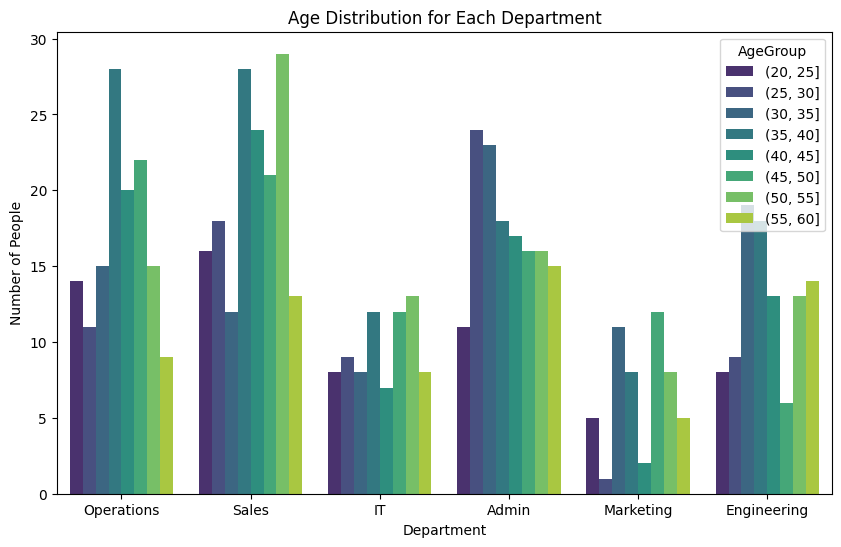

In [87]:
# Set up the matplotlib figure and axes
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='department', hue='AgeGroup', data=employees, palette='viridis')

# Add labels and title
plt.xlabel('Department')
plt.ylabel('Number of People')
plt.title('Age Distribution for Each Department')

**We find that Marketing department contains least number of people in the age group 25-30**

# Age distribution of people across different countries

In [88]:
# Define the age bins
age_bins = list(range(20, 61, 5))

In [89]:
# Create a new 'AgeGroup' column based on the bins
employees['AgeGroup'] = pd.cut(employees['age'], bins=age_bins)

In [97]:
# Set up the matplotlib figure and axes
plt.figure(figsize=(12, 6))

# Create a color mapping dictionary
color_mapping = {
    (20, 25): 'blue',
    (26, 30): 'green',
    (31, 35): 'orange',
    (36, 40): 'red',
    (41, 45): 'purple',
    (46, 50): 'brown'
}

<Figure size 1200x600 with 0 Axes>

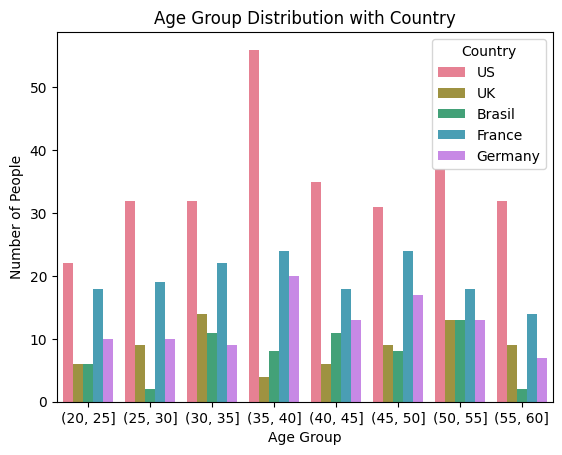

In [105]:
# Use the color mapping in the countplot
ax = sns.countplot(x='AgeGroup', hue='location', data=employees, palette='husl')

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.title('Age Group Distribution with Country')

# Show the plot
plt.legend(title='Country')
plt.show()

**US employs the most number of people of age group 35-40 years**